In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

In [2]:
import sklearn as skl

In [3]:
import scipy

import tensorflow as tf
from skimage import io

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [4]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5220,00027971_000.png,Pneumothorax,0,27971,036Y,F,PA,2650,2778,0.143,0.143
2975,00014664_003.png,Mass,3,14664,057Y,M,AP,2500,2048,0.168,0.168
166,00000963_011.png,Atelectasis,11,963,040Y,M,AP,2500,2048,0.168,0.168


In [5]:
all_xray_df['Patient ID'].nunique()

30805

In [6]:
nsdf=pd.concat([sample_df, sample_df['Finding Labels'].str.get_dummies(sep='|')], axis=1)

In [7]:
## EDA
sample_df=pd.concat([sample_df, sample_df['Finding Labels'].str.get_dummies(sep='|')], axis=1)

In [8]:
## EDA
df=pd.concat([all_xray_df, all_xray_df['Finding Labels'].str.get_dummies(sep='|')], axis=1)

In [9]:
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [10]:
findings=df[['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']]

**Occurence of diseases in %**


In [11]:
(findings.sum()/len(findings))*100

Atelectasis           10.309490
Cardiomegaly           2.475919
Consolidation          4.162504
Edema                  2.054049
Effusion              11.877453
Emphysema              2.244024
Fibrosis               1.503746
Hernia                 0.202462
Infiltration          17.743489
Mass                   5.156975
No Finding            53.836068
Nodule                 5.646629
Pleural_Thickening     3.019087
Pneumonia              1.276311
Pneumothorax           4.728862
dtype: float64

# Demographics

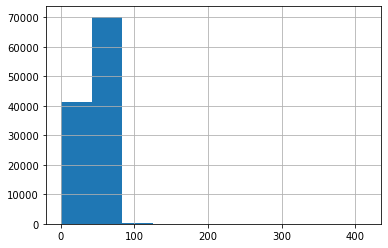

In [12]:
df['Patient Age'].hist()

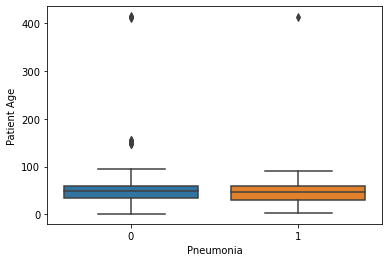

In [13]:
sns.boxplot(df.Pneumonia, df['Patient Age'])

In [14]:
df[df['Patient Age']< 149]['Patient Age'].max()

148

## Cleaning: The age cannot be 148-155

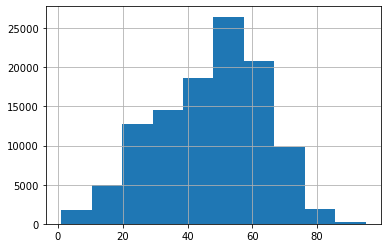

In [15]:
clean=df[df['Patient Age']< 122]
clean['Patient Age'].hist()

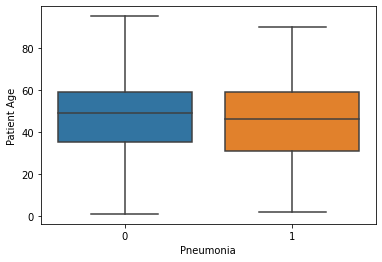

In [16]:
sns.boxplot(clean.Pneumonia, clean['Patient Age'])

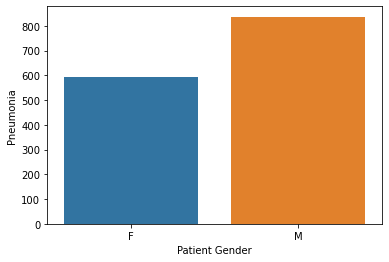

In [17]:
DG=clean.groupby('Patient Gender')
y=DG.Pneumonia.sum()
sns.barplot(y.index, y)

In [20]:
clean.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

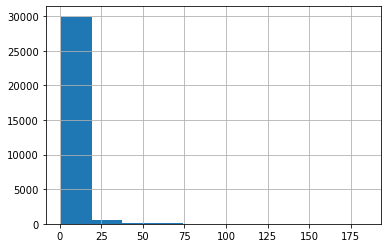

In [21]:
clean.groupby(['Patient ID']).count()['Image Index'].hist()

In [22]:
d=clean.groupby(['Patient ID']).count()['Image Index']
d[d>100]

Patient ID
1836     137
4808     102
6271     108
10007    184
11237    116
12834    157
13111    116
13670    173
13993    143
14022    108
15530    158
17138    117
17236    111
19124    130
19176    108
20213    119
20326    109
21201    114
Name: Image Index, dtype: int64

**sanity checks**
* Gender is either 'M' or 'F'
* Age cannot be an unreasonable number
* n positions per patient
* n followups per patient

**ideas to keep in mind**
* use followups to help with prediction
* different predictions for different genders since the femal images are different from the male images in the chest area.

In [23]:
clean.groupby(['Patient ID'])['Patient Gender'].nunique().max()

1

In [24]:
clean.groupby(['Patient ID'])['View Position'].nunique()

Patient ID
1        1
2        1
3        1
4        1
5        2
        ..
30801    1
30802    1
30803    1
30804    1
30805    1
Name: View Position, Length: 30802, dtype: int64

In [25]:
clean[clean['Patient ID']==10007].nunique()

Image Index                    184
Finding Labels                  42
Follow-up #                    184
Patient ID                       1
Patient Age                      3
Patient Gender                   1
View Position                    2
OriginalImage[Width              3
Height]                          3
OriginalImagePixelSpacing[x      2
y]                               2
Unnamed: 11                      0
Atelectasis                      2
Cardiomegaly                     2
Consolidation                    2
Edema                            2
Effusion                         2
Emphysema                        1
Fibrosis                         2
Hernia                           1
Infiltration                     2
Mass                             2
No Finding                       2
Nodule                           2
Pleural_Thickening               2
Pneumonia                        1
Pneumothorax                     2
dtype: int64

**How many follow ups**

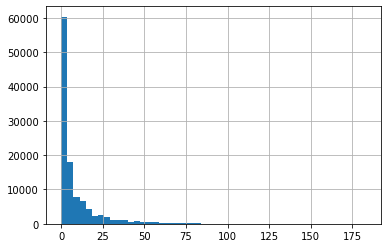

In [26]:
clean['Follow-up #'].hist(bins=50)

# View positions

In [27]:
findings=clean[['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']]

In [28]:
(findings.sum()/len(findings))*100

Atelectasis           10.310069
Cardiomegaly           2.476272
Consolidation          4.163099
Edema                  2.053450
Effusion              11.878256
Emphysema              2.244345
Fibrosis               1.503961
Hernia                 0.202491
Infiltration          17.743345
Mass                   5.155035
No Finding            53.836616
Nodule                 5.647435
Pleural_Thickening     3.018626
Pneumonia              1.275601
Pneumothorax           4.728645
dtype: float64

In [29]:
clean.groupby(['View Position', 'Pneumonia']).count()['Patient ID']

View Position  Pneumonia
AP             0            44005
               1              800
PA             0            66669
               1              630
Name: Patient ID, dtype: int64

In [30]:
clean.groupby(['View Position']).Pneumonia.mean()*100

View Position
AP    1.785515
PA    0.936121
Name: Pneumonia, dtype: float64

**Twice as much pneumonia in AP than in PA**

# Co-Occurences/Comorbidity

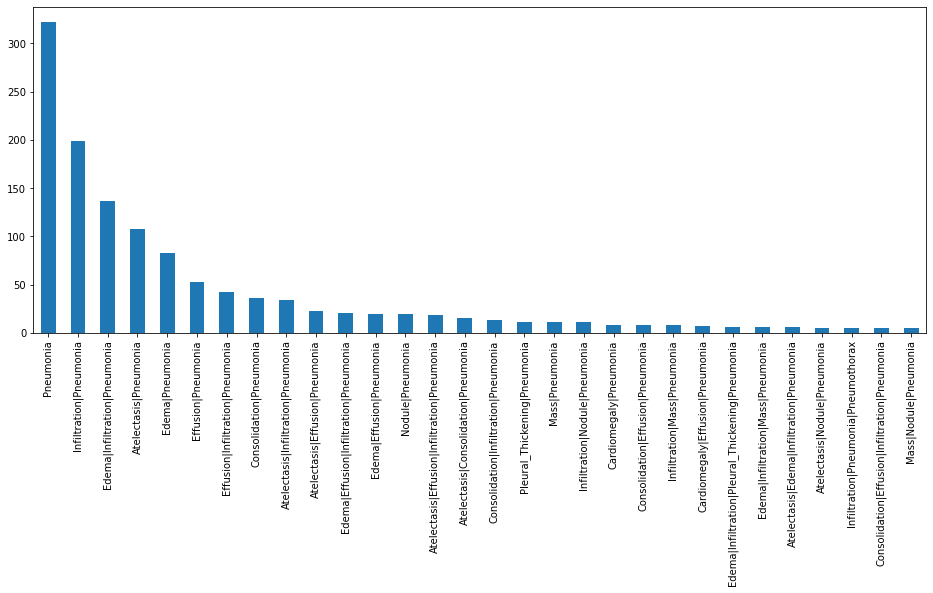

In [25]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
clean[clean.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

In [26]:
clean[clean.Pneumonia==1]['Finding Labels'].value_counts()[0:5]

Pneumonia                       322
Infiltration|Pneumonia          199
Edema|Infiltration|Pneumonia    137
Atelectasis|Pneumonia           108
Edema|Pneumonia                  83
Name: Finding Labels, dtype: int64

In [29]:
findings[findings.Pneumonia==1].mean().map(lambda x:x*100).sort_values()[5:-1]

Pneumothorax           2.865129
Pleural_Thickening     3.354298
Nodule                 4.891684
Mass                   4.961565
Consolidation          8.595388
Atelectasis           18.308875
Effusion              18.798043
Edema                 23.759609
Infiltration          42.278127
dtype: float64

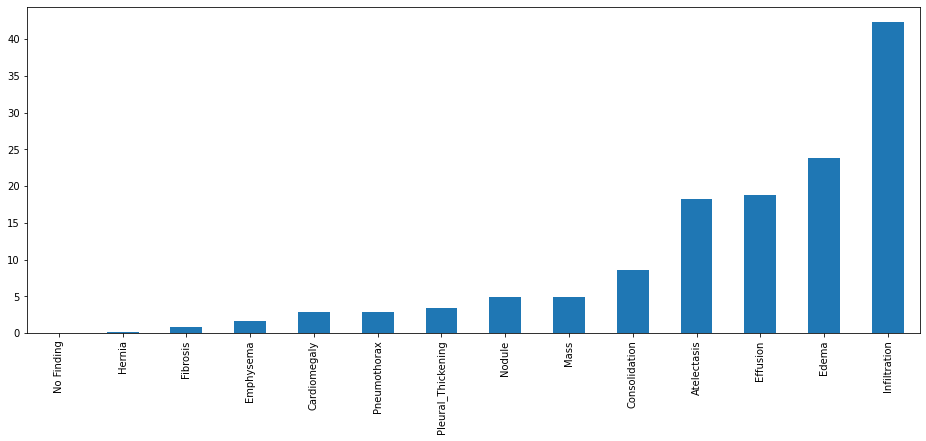

In [28]:
plt.figure(figsize=(16,6))
findings[findings.Pneumonia==1].mean().map(lambda x:x*100).sort_values()[:-1].plot(kind='bar')

In [33]:
findings[findings.Pneumonia==1].sum()

Atelectasis            262
Cardiomegaly            41
Consolidation          123
Edema                  340
Effusion               268
Emphysema               23
Fibrosis                11
Hernia                   3
Infiltration           605
Mass                    71
No Finding               0
Nodule                  70
Pleural_Thickening      48
Pneumonia             1430
Pneumothorax            41
dtype: int64

In [ ]:
df['Patient Age'].mean()

# Does gender affect risk?

In [34]:
d=clean
scipy.stats.ttest_ind(d[d['Patient Gender']== 'F']['Pneumonia'], d[d['Patient Gender']== 'M']['Pneumonia'],nan_policy='omit')

Ttest_indResult(statistic=-1.5668737093527527, pvalue=0.11714703656775026)

In [35]:
clean['nop']=1-clean['Pneumonia']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
d=clean
scipy.stats.ttest_ind(d[d['Patient Gender']== 'F']['nop'], d[d['Patient Gender']== 'M']['nop'],nan_policy='omit')

Ttest_indResult(statistic=1.5668737093526166, pvalue=0.11714703656778207)

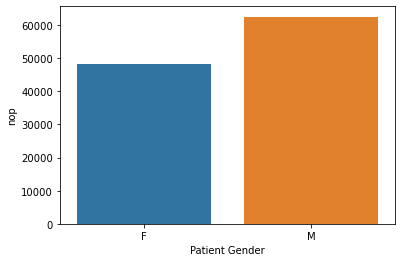

In [37]:
DG=clean.groupby('Patient Gender')
y=DG.nop.sum()
sns.barplot(y.index, y)

In [38]:
scipy.stats.ttest_ind(d[d['Patient Gender']== 'F']['Patient Age'], d[d['Patient Gender']== 'M']['Patient Age'],nan_policy='omit')

Ttest_indResult(statistic=-6.472498414634511, pvalue=9.679136408051127e-11)

In [46]:
(clean['Patient Gender']=='F').mean()

0.435095982302148

In [ ]:
63328+

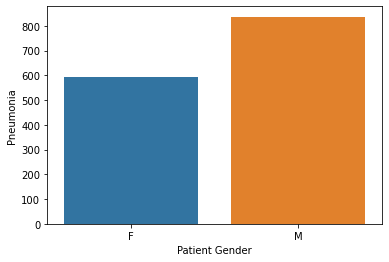

In [32]:
DG=clean.groupby('Patient Gender')
y=DG.Pneumonia.sum()
sns.barplot(y.index, y)

In [33]:
y

Patient Gender
F    593
M    837
Name: Pneumonia, dtype: int64

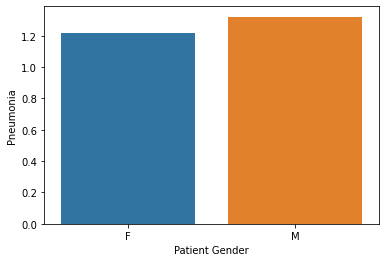

In [30]:
DG=clean.groupby('Patient Gender')
y=DG.Pneumonia.mean()*100
sns.barplot(y.index, y)

In [31]:
y

Patient Gender
F    1.215762
M    1.321690
Name: Pneumonia, dtype: float64

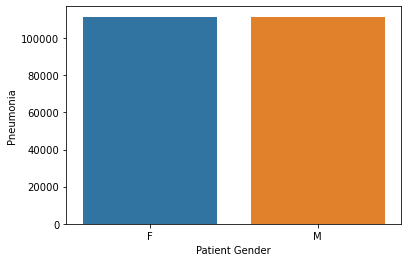

In [41]:
DG=clean.groupby('Patient Gender')
y=len(clean)-DG.Pneumonia.sum()
sns.barplot(y.index, y)

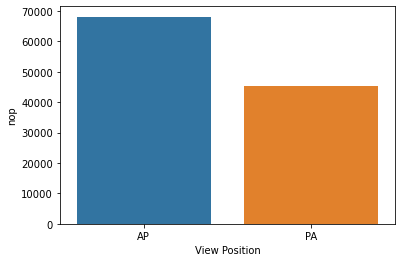

In [42]:
DG=clean.groupby('View Position')
y=len(clean)-DG.nop.sum()
sns.barplot(y.index, y)

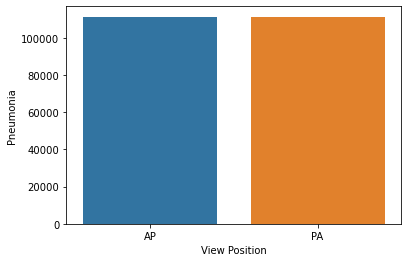

In [43]:
DG=clean.groupby('View Position')
y=len(clean)-DG.Pneumonia.sum()
sns.barplot(y.index, y)

**non significant**

In [44]:
d[d['Patient Gender']== 'F']['Pneumonia'].sum()

593

In [45]:
d[d['Patient Gender']== 'M']['Pneumonia'].sum()

837

In [46]:
(837-593) /593

0.4114671163575042

In [47]:
593 + 593*0.4

830.2

In [48]:
1.5*593

889.5

# Image analysis

In [49]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,1,0,0,1,0,0,0,1,0,1
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,1,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,1,0,0,0,0,0,0,0,0,0
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0,0,0,1,0,0,0,0,0,0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0,0,0,0,0,1,0,0,0,0


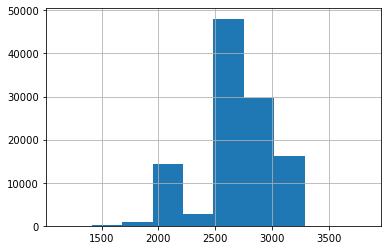

In [50]:
clean['OriginalImage[Width'].hist()

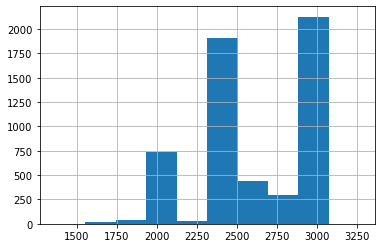

In [51]:
sample_df['OriginalImageWidth'].hist()

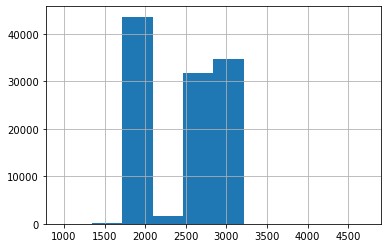

In [52]:
clean['Height]'].hist()

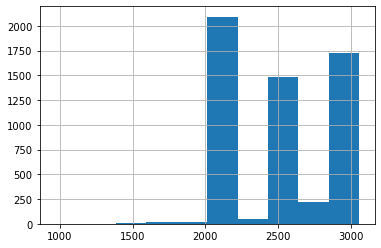

In [53]:
sample_df['OriginalImageHeight'].hist()

In [54]:
len(sample_df)

5606

In [55]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,1,0,0,1,0,0,0,1,0,1
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,1,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,1,0,0,0,0,0,0,0,0,0
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0,0,0,1,0,0,0,0,0,0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0,0,0,0,0,1,0,0,0,0


In [22]:

import pydicom
import glob
import skimage

In [23]:
dicoms = glob.glob("*.dcm")

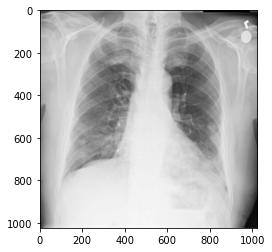

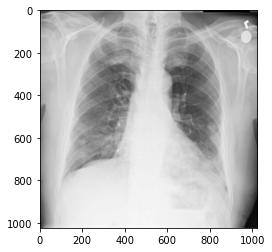

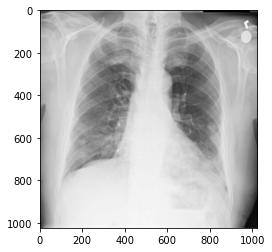

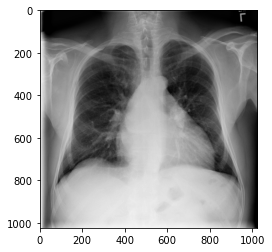

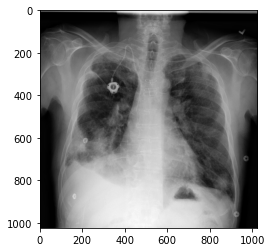

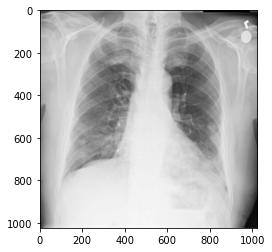

In [58]:
for i in dicoms:
    dcm = pydicom.dcmread(i)
    plt.imshow(dcm.pixel_array,cmap='gray')
    plt.show()

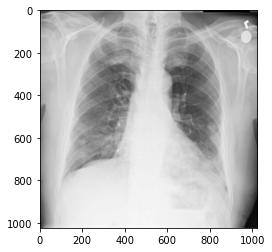

In [59]:
plt.imshow(dcm.pixel_array,cmap='gray')

In [60]:
dcm = pydicom.dcmread(dicoms[1])

In [61]:
dcm.pixel_array

array([[199, 175, 152, ..., 252, 251, 251],
       [150, 128, 114, ..., 243, 250, 252],
       [122, 110, 102, ..., 193, 222, 239],
       ...,
       [ 44,  47,  51, ...,  16,  16,  13],
       [ 44,  48,  52, ...,  16,  16,  14],
       [ 45,  48,  53, ...,  17,  17,  15]], dtype=uint8)

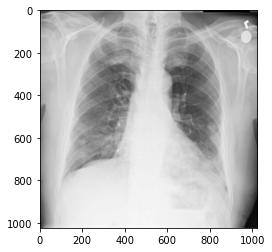

In [62]:
plt.imshow(dcm.pixel_array, cmap='gray')

In [63]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,1,0,0,1,0,0,0,1,0,1
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,1,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,1,0,0,0,0,0,0,0,0,0
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0,0,0,1,0,0,0,0,0,0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0,0,0,0,0,1,0,0,0,0


In [24]:
imgs = glob.glob("/data/images*/images/*.png")

In [25]:
imgmap = dict( (x.split('/')[-1], x) for x in imgs)

In [26]:
clean['imfile']=clean['Image Index'].map(imgmap)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
rDx=clean[clean['Patient Age']==1]

In [ ]:
clean['Patient Age']

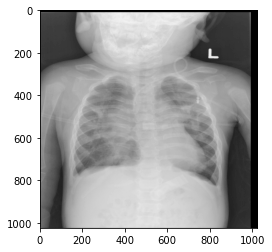

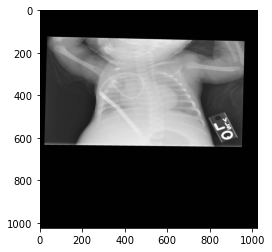

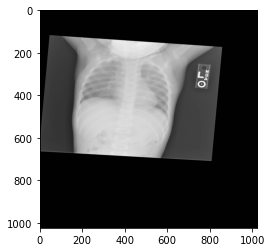

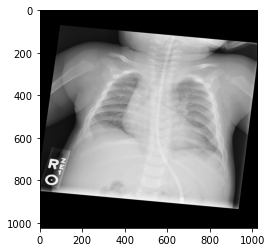

In [42]:
for i in range(4):
    h = plt.imread(rDx.imfile.iloc[i])
    plt.imshow(h, cmap='gray')
    plt.show()

In [66]:
sample_df['imfile']=sample_df['Image Index'].map(imgmap)

In [67]:
f1=sample_df['imfile'].iloc[0]
im1=plt.imread(f1)

In [27]:
def show_hist_imf(imf):
    h = plt.imread(imf).ravel()
    plt.hist(h, bins=250)
    plt.show()

In [69]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,imfile
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,0,0,1,0,0,0,1,0,1,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0,0,0,0,1,0,0,0,0,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0,0,0,0,0,0,0,0,0,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,/data/images_001/images/00000032_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0,0,0,0,1,0,0,0,0,/data/images_012/images/00030712_000.png
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,0,0,0,0,0,0,0,0,0,/data/images_012/images/00030786_005.png
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0,0,1,0,0,0,0,0,0,/data/images_012/images/00030789_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0,0,0,0,1,0,0,0,0,/data/images_012/images/00030792_000.png


In [70]:
def show_hist_imf_norm(imf):
    h = plt.imread(imf).ravel()
    nh= (h - h.mean())/h.std()
    plt.hist(nh, bins=250)
    plt.show()
    
def show_hist_imf_norm_po(imf, pos):
    h = plt.imread(imf).ravel()
    nh= (h - h.mean())/h.std()
    plt.hist(nh, bins=250, label=pos)
    plt.legend()
    plt.show()
    
def show_hist_imf_D(imf, pos):
    h = plt.imread(imf).ravel()
    nh= (h - h.mean())/h.std()
    c = 'r' if pos=='PA' else 'b'
    plt.hist(nh, bins=250, color=c)
    
def show_hist_imf(imf):
    h = plt.imread(imf).ravel()
    nh= (h - h.mean())/h.std()
    plt.hist(nh, bins=250)

In [ ]:
sample_df['pixels']=sample_df.imfile.map(lambda x: plt.imread(x))

In [ ]:
sample_df['ravel']=sample_df['pixels'].map(lambda x: x.ravel())
sample_df['pnorm']=sample_df['ravel'].map(lambda x: (x-x.mean())/x.std())

In [ ]:
sample_df['View Position']

In [ ]:
sample_df[sample_df['View Position']=='AP'][sample_df['Pneumonia']==1].imfile.map(show_hist_imf)
plt.show()
sample_df[sample_df['View Position']=='AP'][sample_df['Pneumonia']==0].imfile.map(show_hist_imf)
plt.show()

In [ ]:
for i in sample_df[['imfile', 'View Position']].iterrows():
    show_hist_imf_D(i[1][0], i[1][1])
    if i[0]>100:
        break
plt.show()

In [ ]:
sample_df.imfile.map(show_hist_imf_norm)

In [ ]:
sample_df.imfile.map(show_hist_imf)

In [ ]:
plt.hist(im1.ravel(), bins=250)
plt.show()

In [ ]:
def get_intensity_mean(imf):
    h = plt.imread(imf).ravel()
    return h.mean()

def get_intensity_std(imf):
    h = plt.imread(imf).ravel()
    return h.std()

In [ ]:
get_intensity_std(f1)

In [ ]:
sample_df['intensiity_mean']=sample_df.imfile.map(get_intensity_mean)

In [ ]:
sample_df.intensiity_mean.hist(bins=100)

In [ ]:
nsdf[nsdf['Pneumonia']==1].intensiity_mean.hist(bins=20)

In [ ]:
nsdf[nsdf['Pneumonia']==0].intensiity_mean.hist(bins=100)

# Reminder for training: standardise images

In [ ]:
pndf=nsdf[nsdf['Pneumonia']==1]
nopndf=nsdf[nsdf['Pneumonia']==0]

In [ ]:
pndf.imfile.iloc[0:10].map(show_hist_imf)

outliers crop?

In [ ]:
nopndf.imfile.iloc[0:10].map(show_hist_imf)

# Image Aug

In [ ]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = sample_df.imfile.iloc[:20]
ind=0

for img, ax in zip(imgs, m_axs):
    img = plt.imread(img)
    ax.imshow(img,cmap='gray')
    ind=ind+1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


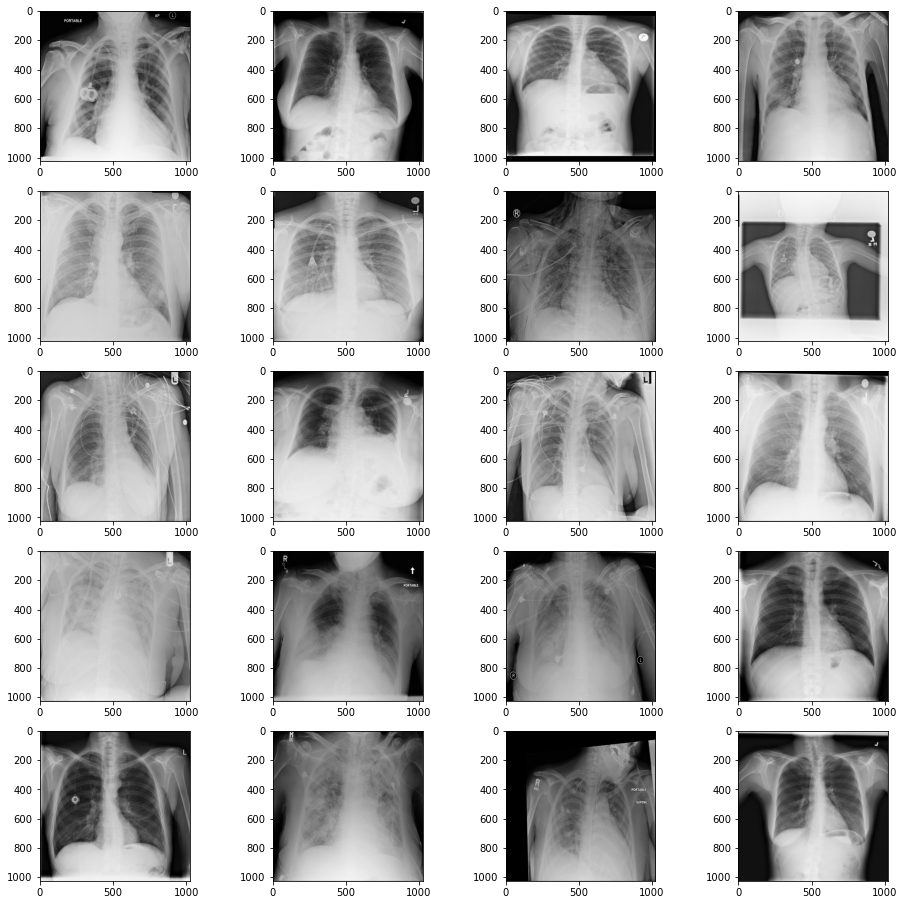

In [115]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
d=sample_df[sample_df['Pneumonia']==1]
imgs = d.imfile.iloc[:20]
ind=0

for img, ax in zip(imgs, m_axs):
    img = plt.imread(img)
    ax.imshow(img,cmap='gray')
    print(d.iloc[ind].Pneumonia)
    ind=ind+1

In [102]:

sample_df.iloc[1]

Image Index                          00000013_026.png
Finding Labels                 Cardiomegaly|Emphysema
Follow-up #                                        26
Patient ID                                         13
Patient Age                                      057Y
Patient Gender                                      M
View Position                                      AP
OriginalImageWidth                               2500
OriginalImageHeight                              2048
OriginalImagePixelSpacing_x                     0.168
OriginalImagePixelSpacing_y                     0.168
Atelectasis                                         0
Cardiomegaly                                        1
Consolidation                                       0
Edema                                               0
Effusion                                            0
Emphysema                                           1
Fibrosis                                            0
Hernia                      